# Conditional Normalizing Flow Model

Here, we train a conditional normalizing flow model $q(x|c)$. Our target $p(x|c)$ is a simple 2D Gaussian $\mathcal{N}(x|\mu, \sigma)$, where we condition on the mean $\mu$ and standard deviation $\sigma$, i.e. $c = (\mu, \sigma)$. We apply conditional autoregressive and coupling neural spline flows as well as a conditional masked autoregressive flow to the problem.

## Workflow
0. Before working in this notebook, you must first run simulations and the preprocess the data as it takes way too long to do interactively.
    1. For simulating data, see work_eic/slurm/makeJobs*
    1. for preprocessing the data see work_eic/macros/Time_estimation/slurm/
    1. These use the slurm batch system to run on the dcc
    1. Once you have run these, you should have a few .pt files that contain tensors that can be read into this notebook
    1. These tensors should have 5 values, the first four being context and the last being the time value which is the feature
1. Load in the data and shuffle it to ensure data is randomly distributed in dataset; then separate into train and test sets
2. Define model
    1. Right now the autoregressive neural spline model seems to work well
    1. We have used masked affine coupling models before in the past but this doesn't seem like it would make sense here as we only have 1 feature and hence cannot mask it
3. Train the model with the training loop (unless you already have a pretrained model)
4. Save the model (or load)
5. Generate samples based on the context of your test dataset
6. Plot timing distribution
    7. The test distribution should match the sampled distribution pretty well since the samples are drawn from the same context as the test data

## Setup

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from util import PVect, theta_func, r_func
from IPython.display import clear_output


Using device cuda:0


In [2]:
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)

In [3]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Data preparation
Need 5 features:
1. Four conditionals:
    1. Hit z position (calculate from shoot position and angle)
    2. mu incident time on scint (calculate from momentum and distance)
    3. hit theta (calculate from momentum vector)
    4. hit momenta (calculate from momentum vector)
2. Feature
    1. photon hit time on sensor

##### Status
1. Hit z, hit theta, hit momenta and photon hit time are all good
1. Just need to calculate hit time from momentum (velocity) and distance traveled (use pythogorean theorem with x and z)

### Preprocess manually below if not loading data

### Load data from .pt file (created by preprocess.py)

July 23rd 600 z pos set: 

In [ ]:
# Timing_path = "/cwork/rck32/eic/work_eic/macros/Timing_estimation/"

# raw_inputs = torch.load(Timing_path + "data/July_24/Run_1/Vary_p_events_file_0_July_23_600_z_pos.pt")
# for i in range(600):
#     clear_output(wait=True)
#     print(f"loaded file #{i+1} of 600")
#     raw_inputs = torch.cat((raw_inputs, torch.load(Timing_path + f"data/July_24/Run_1/Vary_p_events_file_{i+1}_July_23_600_z_pos.pt")),0)

August 6 dataset with revised z hit calc:

In [11]:
Timing_path = "/cwork/rck32/eic/work_eic/macros/Timing_estimation/"

raw_inputs = torch.load(Timing_path + "data/August_06/Run_1/Vary_p_events_file_0_July_23_600_z_pos_fixed_z_hit_pos.pt")
for i in range(600):
    clear_output(wait=True)
    print(f"loaded file #{i+1} of 600")
    raw_inputs = torch.cat((raw_inputs, torch.load(Timing_path + f"data/August_06/Run_1/Vary_p_events_file_{i+1}_July_23_600_z_pos_fixed_z_hit_pos.pt")),0)

loaded file #600 of 600


In [12]:
raw_inputs.shape

torch.Size([513132162, 5])

In [13]:
inputs = raw_inputs[np.logical_and(raw_inputs[:,4] < 100,raw_inputs[:,3] < 0.06)]

/tmp/ipykernel_1078427/2075640514.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  inputs = raw_inputs[np.logical_and(raw_inputs[:,4] < 100,raw_inputs[:,3] < 0.06)]


In [23]:
indexes = torch.randperm(inputs.shape[0])
dataset = inputs[indexes]
train_frac = 0.08
test_frac = 0.01
val_frac = 0.01
train_lim = int(np.floor(dataset.shape[0] * train_frac))
test_lim = train_lim + int(np.floor(dataset.shape[0] * test_frac))
val_lim = test_lim + int(np.floor(dataset.shape[0] * val_frac))
train_data = dataset[:train_lim]
test_data = dataset[train_lim:test_lim]
val_data = dataset[test_lim:val_lim]

In [24]:
train_data.shape

torch.Size([40987094, 5])

In [22]:
# train_data = torch.load(Timing_path + "data/combined/July_23/tenth_600_z_pos_train.pt")
# test_data = torch.load(Timing_path + "data/combined/July_23/tenth_600_z_pos_test.pt")
# val_data = torch.load(Timing_path + "data/combined/July_23/tenth_600_z_pos_val.pt")

uncut: 110166 for 0.001 fraction

sensor time cut: 110155

both cuts: 110114

tighter incident cut (0.06): 110022

In [ ]:
fig, axs = plot.subplots(3,2,figsize = (9,14))
fig.suptitle("test_data 200 z vals")
axs[0,0].hist(test_data[:,0],bins = 1000);
axs[0,0].set_title("hit z pos")
axs[0,0].set_xlabel("mm")

axs[0,1].hist(test_data[:,1],bins = 500);
axs[0,1].set_title("gun theta")
axs[0,1].set_xlabel("theta (degrees)")


axs[1,0].hist(test_data[:,2],bins = 500);
axs[1,0].set_title("mu momentum")
axs[1,0].set_xlabel("(GeV/c)")

axs[1,1].hist(test_data[:,3],bins = 500)
axs[1,1].set_title("mu hit incident time")
axs[1,1].set_xlabel("(ns)")


N, bins, patches = axs[2,1].hist(test_data[:,4],bins = 500)
axs[2,1].set_title("sensor hit times")
axs[2,1].set_xlabel("(ns)")

In [55]:
fig.savefig("plots/inputs/july_21_run_1_sensor_time_incident_time_cuts.pdf")

## Masked Autoregressive Flow

### Model specification

In [13]:
# # Define flows
# K = 4

# latent_size = 1
# hidden_units = 128
# num_blocks = 2
# context_size = 4

# flows = []
# for i in range(K):
#     flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden_units, 
#                                                   context_features=context_size, 
#                                                   num_blocks=num_blocks)]
#     flows += [nf.flows.LULinearPermute(latent_size)]

# # Set base distribution
# q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# # Construct flow model
# model = nf.ConditionalNormalizingFlow(q0, flows)

# # Move model on GPU if available
# model = model.to(device)

## Neural Spline Flow

In [25]:
# Define flows
run_num = 1
run_num_str = str(run_num)

In [26]:
K = 1

latent_size = 1
hidden_units = 128
hidden_layers = 20
context_size = 3
num_context = 3
batch_size= 2000
lr = 1e-5

lr_str = str(lr)
K_str = str(K)
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)
num_context_str = str(num_context)
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)

Create necessary directories

In [27]:
import datetime

x = datetime.datetime.now()
today = x.strftime("%B_%d")
# model_path = "models/context_3/" + today + "/"
# checkdir(model_path)

model_path = "models/" + today + "/"
checkdir(model_path)

loss_path = "plots/loss/" + today + "/"
checkdir(loss_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)


In [28]:
run_info = "run_" + run_num_str+"_"+num_context_str+ "context_"+ K_str + "flows_" + hidden_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs"

### Training

#### Original loop with 4 context params

In [31]:
# # Train model

# num_context = 4
# num_epochs = 1
# max_iter = int(np.floor(train_data.shape[0] / batch_size))

# loss_hist = np.array([])

# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
# for epoch in range(num_epochs):
#     print(f"Beginning epoch #{epoch}")
#     for it in tqdm(range(max_iter)):
#         optimizer.zero_grad()

#         # Get training samples
#         begin = it * batch_size
#         end = (it + 1) * batch_size
#         it_data = train_data[begin:end]
#         context = it_data[:,:num_context].to(device)
#         samples = it_data[:,num_context].unsqueeze(1).to(device)

#         # Compute loss
#         loss = model.forward_kld(samples, context)

#         # Do backprop and optimizer step
#         if ~(torch.isnan(loss) | torch.isinf(loss)):
#             loss.backward()
#             optimizer.step()

#         # Log loss
#         loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

#### Loop with 3 context params

In [32]:
# # Train model

# num_context = 4
# num_epochs = 1
# max_iter = int(np.floor(train_data.shape[0] / batch_size))

# loss_hist = np.array([])

# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# for epoch in range(num_epochs):
#     print(f"Beginning epoch #{epoch}")
#     for it in tqdm(range(max_iter)):
#         optimizer.zero_grad()

#         # Get training samples
#         begin = it * batch_size
#         end = (it + 1) * batch_size
#         it_data = train_data[begin:end]
#         context = torch.empty(it_data.size()[0],3)
#         context[:,0] = it_data[:,0]
#         context[:,1] = it_data[:,1]
#         context[:,2] = it_data[:,2]
#         context = context.to(device)
# #         context = it_data[:,:num_context].to(device)
#         samples = (it_data[:,4] - it_data[:,3]).unsqueeze(1).to(device)

#         # Compute loss
#         loss = model.forward_kld(samples, context)

#         # Do backprop and optimizer step
#         if ~(torch.isnan(loss) | torch.isinf(loss)):
#             loss.backward()
#             optimizer.step()

#         # Log loss
#         loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

#### Train with Validation

In [ ]:
# Train model
num_context = 4
num_epochs = 25
max_iter = int(np.floor(train_data.shape[0] / batch_size))
train_loss_hist = np.array([])
val_loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

validation_frequency = 2000  # Perform validation every 100 training steps
running_loss = 0
global_step = 0
for epoch in range(15,num_epochs):
    print(f"Beginning epoch #{epoch}")
    model.train()  # Set model to training mode
    for it in tqdm(range(max_iter)):
        optimizer.zero_grad()
        # Get training samples
        begin = it * batch_size
        end = (it + 1) * batch_size
        it_data = train_data[begin:end]
        context = torch.empty(it_data.size()[0], 3)
        context[:,0] = it_data[:,0]
        context[:,1] = it_data[:,1]
        context[:,2] = it_data[:,2]
        context = context.to(device)
        samples = (it_data[:,4] - it_data[:,3]).unsqueeze(1).to(device)
        # Compute loss
        loss = model.forward_kld(samples, context)
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        # Log loss
        train_loss_hist = np.append(train_loss_hist, loss.to('cpu').data.numpy())
        running_loss += loss.to('cpu').data.numpy()
        global_step += 1

        # Validation step every 100 training steps
        if global_step % validation_frequency == 0:
            model.eval()  # Set model to evaluation mode
            val_loss = 0
            val_iter = min(100, int(np.floor(val_data.shape[0] / batch_size)))  # Limit validation to 100 batches
            with torch.no_grad():
                for val_it in range(val_iter):
                    begin = val_it * batch_size
                    end = (val_it + 1) * batch_size
                    it_data = val_data[begin:end]
                    context = torch.empty(it_data.size()[0], 3)
                    context[:,0] = it_data[:,0]
                    context[:,1] = it_data[:,1]
                    context[:,2] = it_data[:,2]
                    context = context.to(device)
                    samples = (it_data[:,4] - it_data[:,3]).unsqueeze(1).to(device)
                    loss = model.forward_kld(samples, context)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / val_iter
            print(f"train_loss: {running_loss / validation_frequency}\nval_loss: {avg_val_loss}")
            val_loss_hist = np.append(val_loss_hist, avg_val_loss)
            
#             print(f"Step {global_step} - Train Loss: {train_loss_hist[-1]:.4f}, Val Loss: {avg_val_loss:.4f}")
            
            model.train()  # Set model back to training mode
            running_loss = 0
    model.save(model_path + run_info + f"_checkpoint_e{epoch}.pth")
    print(f"Epoch {epoch} completed.")

Beginning epoch #15


 10%|▉         | 2003/20493 [01:11<29:27, 10.46it/s]

train_loss: 2.1938619037866594
val_loss: 2.190590693950653


 20%|█▉        | 4004/20493 [02:27<18:58, 14.48it/s]

train_loss: 2.193867558002472
val_loss: 2.191644911766052


 29%|██▉       | 6006/20493 [03:46<20:34, 11.73it/s]

train_loss: 2.1928168419599534
val_loss: 2.1935645723342896


 39%|███▉      | 8003/20493 [05:04<19:22, 10.75it/s]

train_loss: 2.1926731078624724
val_loss: 2.1955717110633852


 49%|████▉     | 10005/20493 [06:19<14:54, 11.72it/s]

train_loss: 2.192929314851761
val_loss: 2.193251006603241


 59%|█████▊    | 12007/20493 [07:35<07:58, 17.72it/s]

train_loss: 2.19350412607193
val_loss: 2.191972255706787


 68%|██████▊   | 14003/20493 [08:38<06:56, 15.59it/s]

train_loss: 2.190965178489685
val_loss: 2.1918479990959168


 78%|███████▊  | 16004/20493 [09:51<04:54, 15.24it/s]

train_loss: 2.1895946073532104
val_loss: 2.191723635196686


 88%|████████▊ | 18005/20493 [11:06<03:35, 11.53it/s]

train_loss: 2.190283966302872
val_loss: 2.1972763919830323


 98%|█████████▊| 20005/20493 [12:26<00:40, 11.91it/s]

train_loss: 2.1873245054483412
val_loss: 2.1904100036621093


100%|██████████| 20493/20493 [12:45<00:00, 26.77it/s]


Epoch 15 completed.
Beginning epoch #16


  7%|▋         | 1513/20493 [01:00<23:11, 13.64it/s]

train_loss: 2.19374981379509
val_loss: 2.1909070014953613


 17%|█▋        | 3511/20493 [02:15<23:55, 11.83it/s]

train_loss: 2.1936404404640197
val_loss: 2.1936247658729555


 27%|██▋       | 5514/20493 [03:34<17:49, 14.00it/s]

train_loss: 2.193095761060715
val_loss: 2.195866730213165


 37%|███▋      | 7511/20493 [04:49<19:49, 10.91it/s]

train_loss: 2.1910754712820055
val_loss: 2.19374050617218


 46%|████▋     | 9512/20493 [06:07<15:53, 11.52it/s]

train_loss: 2.1927129284143447
val_loss: 2.19224524974823


 56%|█████▌    | 11511/20493 [07:23<14:02, 10.66it/s]

train_loss: 2.1908650587797167
val_loss: 2.1910948872566225


 66%|██████▌   | 13511/20493 [08:39<10:14, 11.37it/s]

train_loss: 2.1905091733932496
val_loss: 2.191846718788147


 76%|███████▌  | 15511/20493 [09:57<07:17, 11.40it/s]

train_loss: 2.188744994044304
val_loss: 2.1894876623153685


 85%|████████▌ | 17511/20493 [11:14<04:25, 11.23it/s]

train_loss: 2.188084352374077
val_loss: 2.190494120121002


 95%|█████████▌| 19512/20493 [12:29<01:14, 13.17it/s]

train_loss: 2.1875169882774355
val_loss: 2.1923407459259034


100%|██████████| 20493/20493 [13:06<00:00, 26.06it/s]


Epoch 16 completed.
Beginning epoch #17


  5%|▍         | 1020/20493 [00:40<21:45, 14.92it/s]

train_loss: 2.189970633506775
val_loss: 2.199832348823547


 15%|█▍        | 3019/20493 [01:58<25:03, 11.62it/s]

train_loss: 2.1934098529815675
val_loss: 2.1903545093536376


 24%|██▍       | 5018/20493 [03:18<22:33, 11.44it/s]

train_loss: 2.192183357715607
val_loss: 2.1919377613067628


 34%|███▍      | 7020/20493 [04:38<19:15, 11.66it/s]

train_loss: 2.1913722079992293
val_loss: 2.190926535129547


 44%|████▍     | 9019/20493 [05:51<13:39, 14.00it/s]

train_loss: 2.191055386185646
val_loss: 2.190835361480713


 54%|█████▍    | 11018/20493 [07:06<14:15, 11.08it/s]

train_loss: 2.1913005677461626
val_loss: 2.190334620475769


 64%|██████▎   | 13019/20493 [08:18<10:51, 11.47it/s]

train_loss: 2.1890442258119585
val_loss: 2.1887946724891663


 73%|███████▎  | 15019/20493 [09:37<07:54, 11.53it/s]

train_loss: 2.1893102692365645
val_loss: 2.190598268508911


 83%|████████▎ | 17019/20493 [10:57<04:51, 11.94it/s]

train_loss: 2.187828111052513
val_loss: 2.1919691610336303


 93%|█████████▎| 19018/20493 [12:15<02:05, 11.76it/s]

train_loss: 2.187351277589798
val_loss: 2.1893740916252136


100%|██████████| 20493/20493 [13:14<00:00, 25.80it/s]


Epoch 17 completed.
Beginning epoch #18


  3%|▎         | 525/20493 [00:19<29:00, 11.47it/s]

train_loss: 2.189346904873848
val_loss: 2.1894592690467833


 12%|█▏        | 2526/20493 [01:36<23:02, 13.00it/s]

train_loss: 2.194855757594109
val_loss: 2.1900980186462404


 22%|██▏       | 4525/20493 [02:48<22:46, 11.69it/s]

train_loss: 2.1922214967012406
val_loss: 2.1954549288749696


 32%|███▏      | 6526/20493 [04:04<16:11, 14.37it/s]

train_loss: 2.19062775015831
val_loss: 2.1895874619483946


 42%|████▏     | 8524/20493 [05:10<12:30, 15.94it/s]

train_loss: 2.1922653847932816
val_loss: 2.192186186313629


 51%|█████▏    | 10526/20493 [06:23<10:32, 15.76it/s]

train_loss: 2.1905602192878724
val_loss: 2.192198960781097


 61%|██████    | 12526/20493 [07:39<12:02, 11.02it/s]

train_loss: 2.188944677233696
val_loss: 2.189661934375763


 71%|███████   | 14528/20493 [08:57<06:49, 14.56it/s]

train_loss: 2.1886896623373033
val_loss: 2.1884487295150756


 81%|████████  | 16527/20493 [10:12<04:15, 15.49it/s]

train_loss: 2.1871997190713883
val_loss: 2.189088740348816


 90%|█████████ | 18525/20493 [11:20<03:01, 10.87it/s]

train_loss: 2.186543570399284
val_loss: 2.1892227602005003


100%|██████████| 20493/20493 [12:38<00:00, 27.01it/s]


Epoch 18 completed.
Beginning epoch #19


  0%|          | 33/20493 [00:02<31:27, 10.84it/s]

train_loss: 2.187178508400917
val_loss: 2.188446111679077


 10%|▉         | 2032/20493 [01:13<23:59, 12.82it/s]

train_loss: 2.191410469174385
val_loss: 2.188344027996063


 20%|█▉        | 4032/20493 [02:31<24:05, 11.38it/s]

train_loss: 2.19143832886219
val_loss: 2.1915226340293885


 29%|██▉       | 6032/20493 [03:50<22:10, 10.87it/s]

train_loss: 2.1903169165849685
val_loss: 2.1881788754463196


 39%|███▉      | 8033/20493 [05:09<17:31, 11.84it/s]

train_loss: 2.189873103141785
val_loss: 2.1887954688072204


 49%|████▉     | 10033/20493 [06:29<16:15, 10.73it/s]

train_loss: 2.1896122198104857
val_loss: 2.188054904937744


 59%|█████▊    | 12031/20493 [07:44<12:55, 10.92it/s]

train_loss: 2.1906039727926254
val_loss: 2.1878948998451233


 68%|██████▊   | 14032/20493 [09:03<09:53, 10.89it/s]

train_loss: 2.1880340811014176
val_loss: 2.1919769072532653


 78%|███████▊  | 16033/20493 [10:22<06:15, 11.86it/s]

train_loss: 2.1873128513097764
val_loss: 2.187346351146698


 88%|████████▊ | 18032/20493 [11:40<03:45, 10.92it/s]

train_loss: 2.1866174833774568
val_loss: 2.190211410522461


 98%|█████████▊| 20031/20493 [12:59<00:42, 10.81it/s]

train_loss: 2.1849475359916686
val_loss: 2.1900528621673585


100%|██████████| 20493/20493 [13:15<00:00, 25.78it/s]


Epoch 19 completed.
Beginning epoch #20


  8%|▊         | 1540/20493 [01:00<28:52, 10.94it/s]

train_loss: 2.1902381838560103
val_loss: 2.1916765141487122


 17%|█▋        | 3539/20493 [02:17<26:04, 10.84it/s]

train_loss: 2.1912348576784133
val_loss: 2.187561378479004


 27%|██▋       | 5541/20493 [03:37<21:21, 11.67it/s]

train_loss: 2.190926967740059
val_loss: 2.1885266733169555


 37%|███▋      | 7539/20493 [04:56<18:52, 11.44it/s]

train_loss: 2.1908001424074173
val_loss: 2.1893941926956177


 47%|████▋     | 9540/20493 [06:14<15:03, 12.13it/s]

train_loss: 2.1892707802057267
val_loss: 2.188437342643738


 56%|█████▋    | 11540/20493 [07:27<12:37, 11.83it/s]

train_loss: 2.1887572383880616
val_loss: 2.1881817197799682


 66%|██████▌   | 13539/20493 [08:46<10:04, 11.51it/s]

train_loss: 2.187965235590935
val_loss: 2.1881053948402407


 76%|███████▌  | 15540/20493 [10:05<07:31, 10.97it/s]

train_loss: 2.186893783211708
val_loss: 2.1875149703025816


 86%|████████▌ | 17540/20493 [11:23<04:07, 11.92it/s]

train_loss: 2.1860973875522616
val_loss: 2.186979594230652


 95%|█████████▌| 19542/20493 [12:30<00:49, 19.12it/s]

train_loss: 2.185191873192787
val_loss: 2.1894027042388915


100%|██████████| 20493/20493 [13:01<00:00, 26.21it/s]


Epoch 20 completed.
Beginning epoch #21


  5%|▌         | 1048/20493 [00:39<27:16, 11.88it/s]

train_loss: 2.1883027893304825
val_loss: 2.1875844860076903


 15%|█▍        | 3047/20493 [01:53<21:30, 13.52it/s]

train_loss: 2.190826354384422
val_loss: 2.192391836643219


 25%|██▍       | 5047/20493 [03:12<22:23, 11.50it/s]

train_loss: 2.190344914793968
val_loss: 2.1874796462059023


 34%|███▍      | 7049/20493 [04:31<17:01, 13.16it/s]

train_loss: 2.1898956005573273
val_loss: 2.190831770896912


 44%|████▍     | 9047/20493 [05:45<16:13, 11.76it/s]

train_loss: 2.1893447424173353
val_loss: 2.1930909037590025


 54%|█████▍    | 11048/20493 [07:01<10:23, 15.15it/s]

train_loss: 2.189047657489777
val_loss: 2.188604772090912


 64%|██████▎   | 13045/20493 [08:19<11:36, 10.69it/s]

train_loss: 2.1872485637664796
val_loss: 2.187715609073639


 73%|███████▎  | 15050/20493 [09:35<05:15, 17.26it/s]

train_loss: 2.1873543034791947
val_loss: 2.1871604681015016


 83%|████████▎ | 17046/20493 [10:48<04:58, 11.54it/s]

train_loss: 2.1862089015245436
val_loss: 2.1910585880279543


 93%|█████████▎| 19048/20493 [12:07<02:02, 11.76it/s]

train_loss: 2.1848556529283525
val_loss: 2.189357194900513


100%|██████████| 20493/20493 [13:05<00:00, 26.09it/s]


Epoch 21 completed.
Beginning epoch #22


  3%|▎         | 554/20493 [00:21<26:34, 12.51it/s]

train_loss: 2.1866152856349945
val_loss: 2.187899549007416


 12%|█▏        | 2555/20493 [01:29<18:09, 16.46it/s]

train_loss: 2.190595321893692
val_loss: 2.187350182533264


 22%|██▏       | 4554/20493 [02:46<22:28, 11.82it/s]

train_loss: 2.1899828904867173
val_loss: 2.1886525750160217


 32%|███▏      | 6555/20493 [03:47<19:39, 11.81it/s]

train_loss: 2.188968802809715
val_loss: 2.1878528094291685


 42%|████▏     | 8554/20493 [04:52<18:36, 10.69it/s]

train_loss: 2.1889483889341355
val_loss: 2.1889624190330506


 52%|█████▏    | 10556/20493 [06:08<09:16, 17.87it/s]

train_loss: 2.1885888636112214
val_loss: 2.187325830459595


 61%|██████▏   | 12552/20493 [07:22<12:28, 10.61it/s]

train_loss: 2.1872315357923506
val_loss: 2.1938309550285338


 63%|██████▎   | 12969/20493 [07:38<05:01, 24.95it/s]

In [ ]:
# model.save("models/context_3/July_18/run_" + run_num_str+ "_" + K_str + "flows_" + hidden_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs.pth")
model.save(model_path + run_info + ".pth")
           
# model.load("models/July_4/vary_p_uniform_12_flows_8hl_64hu_100bs.pth")

In [ ]:
# Plot loss
plot.figure(figsize=(5, 5))
plot.scatter(range(len(train_loss_hist)),train_loss_hist, np.ones(len(train_loss_hist)) * 0.01, label='loss', alpha = 1)
plot.scatter(np.linspace(0,len(train_loss_hist),len(val_loss_hist)),val_loss_hist, np.ones(len(val_loss_hist)) * 0.1, label='loss', alpha = 1)
plot.savefig( loss_path + run_info + ".jpeg")
plot.legend()
plot.show()

In [ ]:
torch.save(test_data, test_data_path + "full_test_data_run_" + run_num_str+ "_"+ K_str + "flows_" + hidden_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs.pt")

### Evaluation

In [ ]:
min_time = min(inputs[:,4])
skipped = np.array([])

eval_batch_size = 1000
eval_max_iter = test_data.shape[0] // eval_batch_size
eval_test_data = test_data[:eval_max_iter * eval_batch_size]

eval_test_data.to('cpu')
model.to('cpu')
model.eval()
samples = torch.empty(eval_test_data.shape[0])
for i in tqdm(range(eval_max_iter)):
    begin = eval_batch_size * i
    end = eval_batch_size * (i + 1)
    samples[begin:end] = model.sample(num_samples = eval_batch_size, context = test_data[begin:end,:num_context])[0].cpu().detach().squeeze(1)
    

In [ ]:
for i in range(len(samples)):
    if(samples[i] < min_time):
        skipped = np.append(skipped, i)
for i in range(len(skipped) - 1):
    samples = torch.cat((samples[:int(skipped[i])],samples[int(skipped[i] + 1):int(skipped[i + 1])]))
model.train();

### Claude code no resampling, cut

In [30]:
min_time = min(inputs[:, 4])
eval_batch_size = 1000
eval_max_iter = test_data.shape[0] // eval_batch_size
eval_test_data = test_data[:eval_max_iter * eval_batch_size].to('cpu')
model.to('cpu')
model.eval()

samples = []
total_samples = 0
target_samples = eval_test_data.shape[0]

with torch.no_grad():
    pbar = tqdm(total=target_samples)
    while total_samples < target_samples:
        remaining = target_samples - total_samples
        batch_size = min(eval_batch_size, remaining)
        
        batch_samples = model.sample(num_samples=batch_size, 
                                     context=eval_test_data[total_samples:total_samples+batch_size, :num_context])[0]
        
        valid_samples = batch_samples[batch_samples.squeeze(1) >= min_time]
        samples.append(valid_samples)
        
        new_samples = valid_samples.shape[0]
        total_samples += new_samples
        pbar.update(new_samples)

    pbar.close()

samples = torch.cat(samples, dim=0)[:target_samples].squeeze(1)
model.train();

KeyboardInterrupt: 

### Claude code resampling, cut

In [ ]:
min_time = min(inputs[:, 4])
eval_batch_size = 1000
eval_max_iter = test_data.shape[0] // eval_batch_size
eval_test_data = test_data[:eval_max_iter * eval_batch_size].to('cpu')
model.to('cpu')
model.eval()

samples = torch.empty(eval_test_data.shape[0], 1)

with torch.no_grad():
    for i in tqdm(range(eval_max_iter)):
        begin = eval_batch_size * i
        end = eval_batch_size * (i + 1)
        batch_context = eval_test_data[begin:end, :num_context]
        
        batch_samples = model.sample(num_samples=eval_batch_size, context=batch_context)[0]
        valid_mask = batch_samples.squeeze(1) >= min_time
        
        while not valid_mask.all():
            invalid_indices = torch.where(~valid_mask)[0]
            resampled = model.sample(num_samples=len(invalid_indices), 
                                     context=batch_context[invalid_indices])[0]
            batch_samples[invalid_indices] = resampled
            valid_mask[invalid_indices] = resampled.squeeze(1) >= min_time
        
        samples[begin:end] = batch_samples
samples = samples.squeeze(1)
model.train();

In [3]:
# torch.save(samples,"data/samples/vary_p_uniform_6_hl_100_bs.pt")
# torch.save(eval_test_data,"data/test/vary_p_uniform_6_hl_100_bs.pt")

samples = torch.load("data/samples/vary_p_uniform_12_flows_8hl_64hu_100bs.pt")
eval_test_data = torch.load("data/test/vary_p_uniform_12_flows_8hl_64hu_100bs.pt")

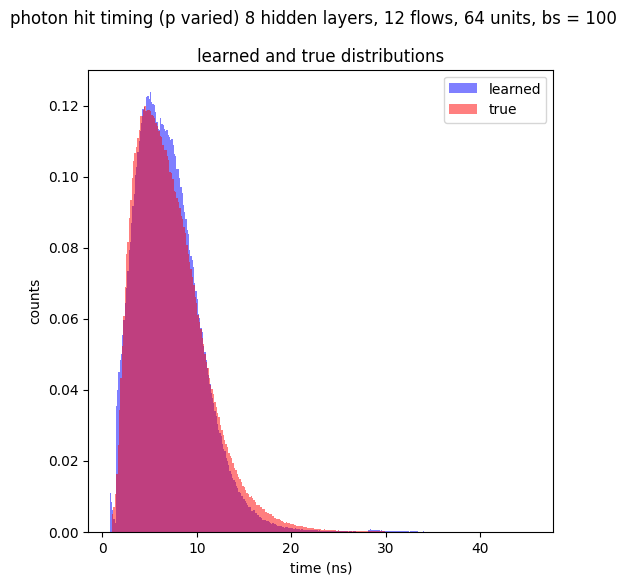

In [49]:
sample_fig, sample_axs = plot.subplots(1,1,figsize=(6,6))
sample_fig.suptitle("photon hit timing (p varied) 8 hidden layers, 12 flows, 64 units, bs = 100")
sample_axs.hist(samples,bins = 300, alpha = 0.5,color = 'b', label = 'learned', density = True)
sample_axs.set_title("learned and true distributions")
sample_axs.set_xlabel("time (ns)")
sample_axs.set_ylabel("counts")
sample_axs.hist(eval_test_data[:,num_context],bins = 300, color = 'r', alpha = 0.5, label = 'true', density = True)
sample_axs.legend(loc='upper right')
sample_fig.show()

In [50]:
sample_fig.savefig("plots/test_distributions/vary_p_uniform_12_flows_8hl_64hu_100bs_normalized_resample.pdf")